20/1 notes:   
TODOs for next time:

- Validate usage of lat/lon in Point API
- Cont: Thresholds of distance and time - to exclude bad trips data.
- Run on more data
- Compare before and after Nativ+

lat = 32....
lon = 34....

Adi Watzman   
Nov. 2019    
The goal of this notebook is to develop tools to measure trip time end-to-end.   
The specific use-case now is to compare trip durations before and after "Nativ +" initiative and analyze the differences (if any).


The main steps:
1. Pick route ids and dates.  
* Query the "Open Bus" splunk database and retrieve siri real time data for these routes in the chosen dates.  
* Query the "Open Bus" splunk database and retrieve GTFS stops locations for these routes.  
* Estimate the time the bus passed in the second** stop and the time it arrived to the last stop, and report their   difference as the trip approximate duration.  

** We use the second stop because it is easier to estimate when a bus passes a stop than estimate the time a bus started its trip. For the first stop there can be many cases such as - bus is very late and drives towards the first stop at the time it was suppose to depart, which can cause false departure time estimation.


In order to retrieve data from our splunk database, I use the [splunk utils](https://github.com/hasadna/open-bus/tree/master/splunk/SplunkUtills) module

# Imports and setup

In [75]:
import datetime
import getpass
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

relative_splunk_utils_path = "../splunk/SplunkUtills"
if relative_splunk_utils_path not in sys.path:
    sys.path.append(relative_splunk_utils_path)

from SplunkUtills import splunk_query_builder, read_splunk

## credentials

In [2]:
with open('/Users/awatzman/Documents/OpenBusDocuments/__credentials.json', 'r') as f:
    credentials = json.load(f)
    
HOST = credentials['host']
PORT = credentials['port']
USERNAME = credentials['username']

In [6]:
# avoid saving the password in a file:
PASSWORD = getpass.getpass()

········


# Templates - Splunk query demo - used for query templates

In [7]:
query = '''search index=route_stats earliest=-20d latest=-10d route_id=5189|
        fields agency_id, route_short_name, route_id, date, all_start_time | '''

GTFS_data = read_splunk(query,
          host =  HOST, port = PORT, username = USERNAME, password = PASSWORD)


start..

your query:
 search index=route_stats earliest=-20d latest=-10d route_id=5189|

        fields agency_id, route_short_name, route_id, date, all_start_time |
 

connection succeed

query status: 100.0%   67 scanned   9 matched   9 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 9



In [8]:
GTFS_data

,agency_id,route_short_name,route_id,date,all_start_time
0,15,501,5189,2020-01-10,05:00:00;05:30:00;05:45:00;06:00:00;06:15:00;0...
1,15,501,5189,2020-01-09,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
2,15,501,5189,2020-01-08,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
3,15,501,5189,2020-01-07,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
4,15,501,5189,2020-01-06,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
5,15,501,5189,2020-01-04,20:00:00;20:01:00;20:15:00;20:30:00;20:45:00;2...
6,15,501,5189,2020-01-03,05:00:00;05:30:00;05:45:00;06:00:00;06:15:00;0...
7,15,501,5189,2020-01-02,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...
8,15,501,5189,2020-01-01,05:00:00;05:15:00;05:45:00;06:05:00;06:23:00;0...


In [9]:
query_kwargs = {
                'index': 'siri',
                'earliest': '-10d', #=last 10 days
                'latest': '-7d',
                #'agency_id': 3,
                'route_short_name': 501,
                'route_id': 5189,
                'planned_start_time': '22:00:00',
               #'max_columns': 100000,
               'columns': ['timestamp','agency_id','route_id','route_short_name','service_id','planned_start_time',
                        'bus_id','predicted_end_time','time_recorded','lat','lon']
                }

SIRI_data = read_splunk(splunk_query_builder(**query_kwargs),
          host =  HOST, port = PORT, username = USERNAME, password = PASSWORD)


start..

your query:
 search index=siri earliest=-10d latest=-7d route_short_name=501 route_id=5189 planned_start_time=22:00:00 |
 fields timestamp, agency_id, route_id, route_short_name, service_id, planned_start_time, bus_id, predicted_end_time, time_recorded, lat, lon |


connection succeed

query status: 100.0%   1201 scanned   59 matched   59 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 59



In [10]:
SIRI_data

,timestamp,agency_id,route_id,route_short_name,service_id,planned_start_time,bus_id,predicted_end_time,time_recorded,lat,lon
0,2020-01-11T22:51:13,15,5189,501,42135488,22:00:00,86345501,22:52:00,22:51:09,32.059048,34.784203
1,2020-01-11T22:50:12,15,5189,501,42135488,22:00:00,86345501,22:52:00,22:49:20,32.062607,34.784985
2,2020-01-11T22:48:13,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:47:55,32.065784,34.786530
3,2020-01-11T22:47:12,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:46:55,32.069584,34.787888
4,2020-01-11T22:46:13,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:45:31,32.074688,34.790630
5,2020-01-11T22:45:12,15,5189,501,42135488,22:00:00,86345501,22:52:00,22:45:07,32.076332,34.791653
6,2020-01-11T22:44:12,15,5189,501,42135488,22:00:00,86345501,22:50:00,22:43:31,32.079651,34.793713
7,2020-01-11T22:43:13,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:43:05,32.081501,34.794254
8,2020-01-11T22:42:12,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:41:49,32.090523,34.795265
9,2020-01-11T22:41:12,15,5189,501,42135488,22:00:00,86345501,22:51:00,22:40:43,32.095417,34.794125


# Get Data

## Pick route ids and dates

Use the route_stats and trip_stats [docs](https://open-bus-gtfs-utils.readthedocs.io/en/latest/trip_stats.html) to find relevant data fields.

In [11]:
# human-friendly settings:
route_short_name = '601'
earliest = "10/30/2019:00:00:00"
latest = "10/31/2019:23:59:59"

In [12]:
# find relevant route ids:

get_route_ids_q = '''
search 
    index=route_stats 
    earliest="{earliest}"
    latest="{latest}" 
    route_short_name={route_short_name} |
fields 
    date, 
    agency_id, 
    route_short_name, 
    route_id,
    start_stop_city,
    start_stop_name,
    end_stop_city,
    end_stop_name,
    all_start_time | 
'''.format(earliest=earliest, latest=latest, route_short_name=route_short_name)

route_ids = read_splunk(get_route_ids_q,
                        host=HOST, port=PORT, username=USERNAME, password=PASSWORD)


start..

your query:
 
search 
    index=route_stats 
    earliest="10/30/2019:00:00:00"
    latest="10/31/2019:23:59:59" 
    route_short_name=601 |

fields 
    date, 
    agency_id, 
    route_short_name, 
    route_id,
    start_stop_city,
    start_stop_name,
    end_stop_city,
    end_stop_name,
    all_start_time |
 


connection succeed

query status: 100.0%   102 scanned   6 matched   6 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 6



In [13]:
route_ids

,date,agency_id,route_short_name,route_id,start_stop_city,start_stop_name,end_stop_city,end_stop_name,all_start_time
0,2019-10-31,15,601,18077,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,19:35:00;20:05:00;20:40:00;21:20:00;21:35:00;2...
1,2019-10-31,15,601,700,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,05:40:00;06:00:00;06:15:00;06:30:00;06:40:00;0...
2,2019-10-31,15,601,698,נתניה,ת. רכבת נתניה,תל אביב יפו,ת. מרכזית ת''א ק. 6/הורדה,05:30:00;06:00:00;06:20:00;06:40:00;06:50:00;0...
3,2019-10-30,15,601,18077,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,19:35:00;20:05:00;20:40:00;21:20:00;21:35:00;2...
4,2019-10-30,15,601,700,תל אביב יפו,ת.מרכזית ת''א ק.6/רציפים,נתניה,ת. רכבת נתניה,05:40:00;06:00:00;06:15:00;06:30:00;06:40:00;0...
5,2019-10-30,15,601,698,נתניה,ת. רכבת נתניה,תל אביב יפו,ת. מרכזית ת''א ק. 6/הורדה,05:30:00;06:00:00;06:20:00;06:40:00;06:50:00;0...


In [14]:
#route_ids.all_start_time.str.split(';').apply(lambda x: sorted(x)).values

Choose the relevat route id and continue:

In [15]:
route_id = '698' # Netanya -> TLV

## Retreive SIRI data

In [16]:
siri_cols = ['timestamp','agency_id','route_id','route_short_name','service_id','planned_start_time',
             'planned_start_date', 'bus_id','predicted_end_time','time_recorded', 'date_recorded', 'lat', 'lon']
query_kwargs = {
                'index': 'siri',
                'earliest': earliest, 
                'latest': latest,
                'route_id': route_id,
                'columns': siri_cols
                }

siri_data = read_splunk(splunk_query_builder(**query_kwargs),
                        host=HOST, port=PORT, username=USERNAME, password=PASSWORD)

start..

your query:
 search index=siri earliest=10/30/2019:00:00:00 latest=10/31/2019:23:59:59 route_id=698 |
 fields timestamp, agency_id, route_id, route_short_name, service_id, planned_start_time, planned_start_date, bus_id, predicted_end_time, time_recorded, date_recorded, lat, lon |


connection succeed

query status: 100.0%   12844 scanned   11530 matched   11530 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 11530



In [17]:
siri_data['planned_start_datetime'] = pd.to_datetime(siri_data.planned_start_date + 'T' + siri_data.planned_start_time)
siri_data['datetime_recorded'] = pd.to_datetime(siri_data.date_recorded + 'T' + siri_data.time_recorded)


## Retreive stops locations (GTFS)

Get the all_stop_latlon from route_stats of the relevant route!.   
https://open-bus-gtfs-utils.readthedocs.io/en/latest/index.html

In [18]:
stops_cols = ['route_id', 'date', 'all_stop_id', 'all_stop_code',  'all_stop_latlon']
stops_query_kwargs = {
                      'index': 'route_stats',
                      'earliest': earliest, 
                      'latest': latest,
                      'route_id': route_id,
                      'columns': stops_cols
                      }

stops_data_raw = read_splunk(splunk_query_builder(**stops_query_kwargs),
                             host=HOST, port=PORT, username=USERNAME, password=PASSWORD)

start..

your query:
 search index=route_stats earliest=10/30/2019:00:00:00 latest=10/31/2019:23:59:59 route_id=698 |
 fields route_id, date, all_stop_id, all_stop_code, all_stop_latlon |


connection succeed

query status: 100.0%   24 scanned   2 matched   2 results

Done!

query succeed

read results succeed

job finished and canceled

finished! number of rows: 2



In [19]:
stops_data_raw # one row per route id and date

,route_id,date,all_stop_id,all_stop_code,all_stop_latlon
0,698,2019-10-31,24323;333;358;42546;324;320;309;307;302;291;28...,36875;39247;39273;32196;39237;39233;39222;3922...,"32.319671,34.868105;32.325694,34.864841;32.326..."
1,698,2019-10-30,24323;333;358;42546;324;320;309;307;302;291;28...,36875;39247;39273;32196;39237;39233;39222;3922...,"32.319671,34.868105;32.325694,34.864841;32.326..."


In [20]:
def get_stops_df_per_route_date(row, stops_seq_cols=['all_stop_id', 'all_stop_code', 'all_stop_latlon']):
    """ Create dataframe with a row for each stop
    Input: row - a row of a df generated by the above splunk stops query.
    """
    stops_dict = row.to_dict()
    
    # split each cell with stops sequence:
    for col in stops_seq_cols:
        stops_dict[col] = stops_dict[col].split(';')
    
    # enumerate the stops in the sequence:
    seq_len = len(stops_dict[stops_seq_cols[0]])
    stops_dict['stop_order'] = list(range(seq_len))
    
    return pd.DataFrame(stops_dict)

In [22]:
# reshape the stops_data df to have one row per route_id, date and stop:
stops_df = pd.concat([get_stops_df_per_route_date(row) for ind, row in stops_data_raw.iterrows()], axis=0)
stops_df.columns = [col.replace('all_', '') for col in stops_df.columns]
stops_df[['lat', 'lon']] = stops_df.stop_latlon.str.split(',', expand=True).astype(float)
stops_df

,route_id,date,stop_id,stop_code,stop_latlon,stop_order,lat,lon
0,698,2019-10-31,24323,36875,"32.319671,34.868105",0,32.319671,34.868105
1,698,2019-10-31,333,39247,"32.325694,34.864841",1,32.325694,34.864841
2,698,2019-10-31,358,39273,"32.326819,34.862473",2,32.326819,34.862473
3,698,2019-10-31,42546,32196,"32.326629,34.857538",3,32.326629,34.857538
4,698,2019-10-31,324,39237,"32.324201,34.856548",4,32.324201,34.856548
...,...,...,...,...,...,...,...,...
42,698,2019-10-30,13103,21472,"32.074914,34.790734",42,32.074914,34.790734
43,698,2019-10-30,13206,21675,"32.07189,34.789291",43,32.071890,34.789291
44,698,2019-10-30,39960,20143,"32.066005,34.786424",44,32.066005,34.786424
45,698,2019-10-30,13277,22947,"32.061357,34.78463",45,32.061357,34.784630


# WIP - Estimate trip time

In [23]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from geopy.distance import geodesic

In [98]:
# define a function to get: stops_df, ord_trip_df, stop_ind, dt_at_stop_func
# and returns the datetime and exact GPS for being at this stop approximated by the chosen func

def closest_to_point(trip_df, point_lat, point_lon):
    """ Find the time and location of the bus which is closest to the given point.
    
    Return: Datetime and GPS of the closest point from the dataset to the stop point.
    
    ###TODO - allow constraining on max distance from point
    ###TODO - allow relativeness - closest location before/after point, ...
    ###TODO - how do we deal with circular routes (that pass close to a point several times)
    """
    trip_points = MultiPoint(trip_df[['lat', 'lon']].values)
    point = Point(point_lat, point_lon)
    nrst, _ = nearest_points(trip_points, point)
    
    # basic validations on the point detected:
    print((point_lat, point_lon))
    print((nrst.y, nrst.x))
    if geodesic((point_lat, point_lon), (nrst.x, nrst.y)).km > 5:
        raise "too high dist, should return NULL somehow"

    
    trip_row = trip_df[(trip_df.lat == nrst.x) & (trip_df.lon == nrst.y)] 
    ## TODO - take care of the corner case when we get more than 1 row here

    dt = trip_row.datetime_recorded.values[0]
    pnt = trip_row[['lat', 'lon']].values[0]
    
    
    
    return dt, pnt


def detect_bus_at_stops(trip_df, stops_df, stops_inds, time_at_stop_func):
    """ Estimate the time a bus was located at the given stops.
    
    params:
    trip_df: pandas df, siri data for the relevant trip.
             With columns: ###todo continue documentation, 
             ordered in ascending order by 'datetime_recorded'.
    stops_df: pandas df, GTFS shape for the relevant route.
              With columns: ###todo continue documentation, 
              ordered by 'stop_order'
    stops_inds: Iterable. Indices of the stops at which the bus should be detected 
                (corresponding to stop_order). ##TODO - allow a single index 
    time_at_stop_func: function with input: trip_df, GPS point; 
                       and output: estimated time and location of the bus in this point.
                       ## TODO - allow additional args to be sent to time_at_stop_func
    
    Return: dict of: {stop_ind: (time, location Point)}
    """
    bus_at_stops = dict()
    for ind in stops_inds:
        point_lat, point_lon = stops_df[stops_df.stop_order == ind]\
                                             [['lat', 'lon']].values.flatten()
        bus_at_stops[ind] = time_at_stop_func(trip_df, point_lat, point_lon) 
    return bus_at_stops

In [100]:
## TODO - in a more advanced implementation - create a class for a trip, that holds the trips siri data
# and the GTFS stops data, and a class method to estimate the trip time as below. 

def trip_time(siri_trip, stops_df, stop1=1, stop2=-2):
    """ Estimate the time it took the bus to travel between the second and last stops 
    
    Params:
    siri_trip: pandas df with the siri data of one trip. 
               Each row represents the bus location at a given time. 
               Required columns: datetime_recorded, route_id, date_recorded, 

    stop_ds: pandas df with the GTFS data of the trip's corresponding route.
             Each row represents one stop.
             Required columns: 
             
    return: float, estimated number of minutes between stop1 and stop2.
             
    """
    # sort and drop dups:
    ord_trip = siri_trip.sort_values('datetime_recorded') 
    ord_trip = ord_trip.drop_duplicates(subset=['datetime_recorded', 'lat', 'lon'], 
                                        keep='first') 
    
    # extract the sequence of scheduled stops for this trip
    ## TODO - in a more advanced implementation, take this processing out of the per-trip function!
    stops_for_trip = stops_df[(stops_df.route_id == ord_trip.route_id.iloc[0]) & 
                              (stops_df.date == ord_trip.date_recorded.iloc[0])]

    # convert negative stops indices:
    if stop1 < 0:
        stop1 = stops_for_trip.stop_order.values[stop1]
    if stop2 < 0:
        stop2 = stops_for_trip.stop_order.values[stop2]
#     print("stops:", stop1, '->', stop2) # TODO add "if verbose..."

    # trip time (for now, very naive and rough estimation of the trip between second and last stop):
    bus_at_stops = detect_bus_at_stops(trip_df=ord_trip, 
                                       stops_df=stops_for_trip, 
                                       stops_inds=[stop1, stop2], 
                                       time_at_stop_func=closest_to_point)
    
    t = bus_at_stops[stop2][0] - bus_at_stops[stop1][0]
    t_minutes = t / np.timedelta64(1, 'm')
    return t_minutes 
    

In [101]:
# group siri by trip, and get the trip time for each trip: 
trip_params = ['planned_start_datetime', 'agency_id', 'route_id', 'route_short_name', 'bus_id']
res = []
for ids, grp in siri_data[siri_data.lat > 0].groupby(trip_params, sort=True):
    t = trip_time(grp, stops_df)
#     res.append((ids[0], t))
    res.append((*ids, t))

res_df = pd.DataFrame(res, columns=trip_params + ['est_trip_time_minute'])
res_df.shape


### TODO - continue from here - make sure lat and lon are used correctly! then continue with constraining unreasonable points!

(32.325694, 34.864841)
(34.857837677001946, 32.32711410522461)
(32.061357, 34.78463)
(34.82741165161133, 32.21442413330078)


TypeError: exceptions must derive from BaseException

In [62]:
res_df

,planned_start_datetime,agency_id,route_id,route_short_name,bus_id,est_trip_time_minute
0,2019-10-30 05:30:00,15,698,601,47080001,169.866667
1,2019-10-30 06:00:00,15,698,601,47089901,62.466667
2,2019-10-30 06:20:00,15,698,601,47085301,0.000000
3,2019-10-30 06:40:00,15,698,601,47094101,96.883333
4,2019-10-30 06:50:00,15,698,601,47086201,84.133333
...,...,...,...,...,...,...
93,2019-10-31 20:30:00,15,698,601,47088301,-6.866667
94,2019-10-31 21:00:00,15,698,601,86339001,51.250000
95,2019-10-31 21:30:00,15,698,601,65858901,0.000000
96,2019-10-31 22:05:00,15,698,601,47085801,55.716667


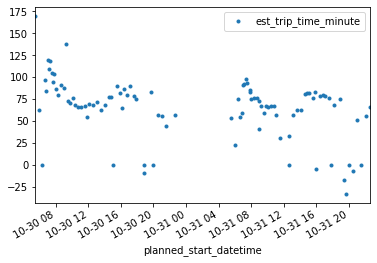

In [63]:
res_df.plot('planned_start_datetime', 'est_trip_time_minute', ls='', marker='.')
plt.show()

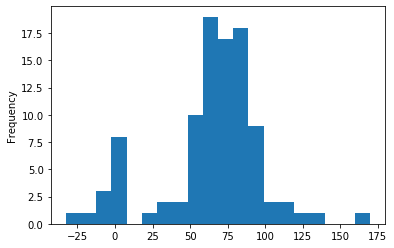

In [64]:
res_df.est_trip_time_minute.plot.hist(bins=20)
plt.show()

**TODO - investigate the cause for non positive trip time!**


In [60]:
res_df[res_df.est_trip_time_minute <= 0].sort_values('planned_start_datetime')

,planned_start_datetime,agency_id,route_id,bus_id,est_trip_time_minute
2,2019-10-30 06:20:00,15,698,47085301,0.000000
31,2019-10-30 15:05:00,15,698,47086701,0.000000
40,2019-10-30 18:50:00,15,698,47089201,-9.050000
41,2019-10-30 18:50:00,15,698,47091201,0.000000
43,2019-10-30 20:00:00,15,698,65856301,0.000000
73,2019-10-31 12:35:00,15,698,47094301,0.000000
82,2019-10-31 15:57:00,15,698,47088301,-4.100000
87,2019-10-31 17:50:00,15,698,47091501,0.000000
90,2019-10-31 19:20:00,15,698,47085101,-17.433333
91,2019-10-31 19:40:00,15,698,65859701,-32.750000


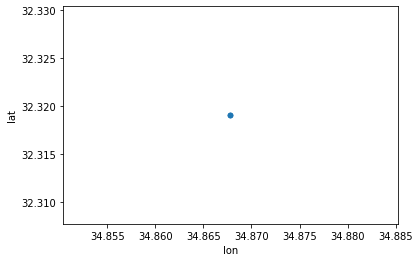

In [85]:
plot_geo_points(siri_data[(siri_data.planned_start_datetime == '2019-10-30 15:05:00') & 
                          (siri_data.lat > 0)].sort_values('datetime_recorded'))

In [86]:
siri_data[(siri_data.planned_start_datetime == '2019-10-30 15:05:00') & 
                          (siri_data.lat > 0)].sort_values('datetime_recorded')

,timestamp,agency_id,route_id,route_short_name,service_id,planned_start_time,planned_start_date,bus_id,predicted_end_time,time_recorded,date_recorded,lat,lon,planned_start_datetime,datetime_recorded
7461,2019-10-30T15:04:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:00:00,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:00:00
7467,2019-10-30T15:03:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:00:00,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:00:00
7472,2019-10-30T15:02:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:00:00,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:00:00
7477,2019-10-30T15:01:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:00:00,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:00:00
7483,2019-10-30T15:00:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:00:00,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:00:00
7450,2019-10-30T15:06:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:05:02,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:05:02
7456,2019-10-30T15:05:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:05:02,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:05:02
7444,2019-10-30T15:07:17,15,698,601,42325835,15:05:00,2019-10-30,47086701,16:07:00,15:07:08,2019-10-30,32.319092,34.867817,2019-10-30 15:05:00,2019-10-30 15:07:08


In [ ]:
plot_geo_points(siri_data[siri_data.lat > 0])

In [65]:
res_df[res_df.planned_start_datetime == '2019-10-30 18:50:00']

,planned_start_datetime,agency_id,route_id,route_short_name,bus_id,est_trip_time_minute
40,2019-10-30 18:50:00,15,698,601,47089201,-9.05
41,2019-10-30 18:50:00,15,698,601,47091201,0.00


In [79]:
res_df[res_df.planned_start_datetime.dt.date == datetime.date(2019, 10, 30)].sort_values('planned_start_datetime')

,planned_start_datetime,agency_id,route_id,route_short_name,bus_id,est_trip_time_minute
0,2019-10-30 05:30:00,15,698,601,47080001,169.866667
1,2019-10-30 06:00:00,15,698,601,47089901,62.466667
2,2019-10-30 06:20:00,15,698,601,47085301,0.000000
3,2019-10-30 06:40:00,15,698,601,47094101,96.883333
4,2019-10-30 06:50:00,15,698,601,47086201,84.133333
5,2019-10-30 07:00:00,15,698,601,65860001,120.100000
6,2019-10-30 07:10:00,15,698,601,47090801,109.100000
7,2019-10-30 07:20:00,15,698,601,47089701,118.083333
8,2019-10-30 07:30:00,15,698,601,47091801,104.716667
9,2019-10-30 07:40:00,15,698,601,86338701,94.266667


In [46]:
# i = 0
# # group siri by trip: 
# # (In real code this should iterate over all trips, now we stop at one to build the code)
# for ids, grp in siri_data[siri_data.lat > 0] \
#                         .groupby(['planned_start_datetime', 'agency_id', 'route_id', 'bus_id'],
#                                  sort=True):
#     if i == 11: # just for debug, choose arbitrary trip (group of siri entries)
#         break
#     i += 1
# print(ids)
# ord_trip = grp.sort_values('time_recorded') # sort
# ord_trip = ord_trip.drop_duplicates(subset=['datetime_recorded', 'lat', 'lon'], keep='first') # drop dups

# ord_trip.shape

(Timestamp('2019-10-30 08:00:00'), 15, 698, 47085801)


(83, 15)

In [121]:
# extract the sequence of scheduled stops for this trip
stops_for_trip = stops_data2[(stops_data2.route_id == ord_trip.route_id.iloc[0]) & 
                             (stops_data2.date == ord_trip.date_recorded.iloc[0])]
# extract last stop ind:
last_stop_ind = stops_for_trip.stop_order.max()

# Estimate the time when the bus passed these stops (very naive and rough estimation for now):
bus_at_stops = detect_bus_at_stops(trip_df=ord_trip, 
                                   stops_df=stops_for_trip, 
                                   stops_inds=[1, last_stop_ind], 
                                   time_at_stop_func=closest_to_point)

## vizualization for validation

In [80]:
def plot_geo_points(df, ax=None):
    """ df with 'lon' and 'lat' columns"""
    ax = df.plot.scatter('lon', 'lat', alpha=0.5, ax=ax)

    ax.axis('equal')
    return ax

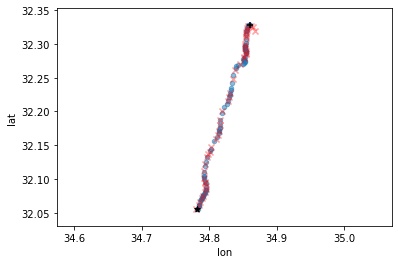

In [127]:
# vizualization for validation
ax = ord_trip.plot.scatter('lon', 'lat', alpha=0.5) # bus gps
ax.scatter(stops_data2.lon, stops_data2.lat, color='r', marker='x', alpha=0.2) # stops

lon, lat = bus_at_stops[1][1]
ax.scatter(lat, lon, marker='+', color='k') # second stop

lon, lat = bus_at_stops[last_stop_ind][1]
ax.scatter(lat, lon, marker='*', color='k') # last stop

ax.axis('equal')
plt.show()

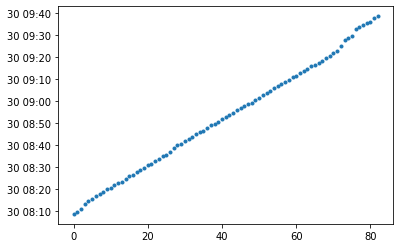

In [128]:
# sanity check - entries by "time recorded"
plt.plot(ord_trip.datetime_recorded.reset_index(drop=True), marker='.', ls='')
plt.show()

# TODO - run on larger scale - to get statistics.

# TODO - convert the important code parts to a generic module